In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier 
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sklearn.metrics import r2_score,confusion_matrix
from sklearn.linear_model import Ridge


# Reading Central & Satellite data

In [2]:
cent_data = pd.read_csv('central/cenlgMh_mmcspenvani_1.txt', sep=",", header=None)
str1 = "central/cenlgMh_mmcspenvani_"
for i in range(2,26):
    file2 = str1 + str(i) + '.txt'
    data2 = pd.read_csv(file2, sep=",", header=None)
    cent_data = cent_data.append(data2,ignore_index = True)
    print(i)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [3]:
sat_data = pd.read_csv('satellite/new_satlgMh9col_1.txt', sep=",", header=None)
str1 = "satellite/new_satlgMh9col_"
for i in range(2,26):
    file2 = str1 + str(i) + '.txt'
    data2 = pd.read_csv(file2, sep=",", header=None)
    sat_data = sat_data.append(data2,ignore_index = True)
    print(i)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


## Defining all columns of central and satellites

In [4]:
cent_data.columns = ['galaxyID','fofCentralId','subHaloID','phkey','con','mvir','vmax','a05','a08','vpeak',
'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg','stellarMass','fofID',
'centralMvir','x','y','z','type','spinX','spinY','spinZ','g1_25','g2_5','g5','g10','alpha']

In [5]:
cent_data['total_spin'] = ((cent_data.spinX)**2 + 
(cent_data.spinY)**2 + (cent_data.spinZ)**2)**(1/2)
cent_data['total_spin'] = cent_data['total_spin']/cent_data['centralMvir']

In [6]:
sat_data.columns = ['galaxyID','fofCentralId','stellarMass','fofID','centralMvir','x','y','z','con']

In [7]:
def index_reset_drop(df):
    df = df.reset_index()
    return df.drop(columns=['index'])

In [8]:
# sat_data_above is a pd df which contains data from sat_data 
# (entire satellite dataset) with m > 1.42.

sat_data_above = sat_data[sat_data['stellarMass'] > 1.42]
sat_data_above = index_reset_drop(sat_data_above)

# haloID_above contains the fofID (haloID) of sat_data_above
# sat_data_above["fofID"].value_counts() returns 2 columns: fofID and 
# #of satellites as a pandas.core.series.Series in the decreasing order
# of #of sats.
# .index returns the fofIDs column as a pandas.core.indexes.numeric.Int64Index
# .values returns the fofIDs column as a np array

haloID_above = sat_data_above["fofID"].value_counts().index.values

In [9]:
# sat_data_below is a pd df which contains data from sat_data 
# (entire satellite dataset) with m < 1.42.

sat_data_below = sat_data[~sat_data['fofID'].isin(haloID_above)]
sat_data_below = index_reset_drop(sat_data_below)

sat_data_below.head()

,galaxyID,fofCentralId,stellarMass,fofID,centralMvir,x,y,z,con
0,10022714000024,10022714000000,0.000056,63001000016093,1.118854,0.341687,97.447760,224.98695,0.619767
1,14016663000018,14016663000000,0.000647,63001400015295,1.118854,105.567570,4.216068,240.00592,1.185708
2,33018471000019,33018471000000,0.000874,63003200015601,1.118854,194.013030,173.817210,58.41450,1.110460
3,42019019000012,42019019000000,0.000427,63004100019974,1.118854,205.166170,162.611430,229.33305,1.160042
4,85008109000022,85008109000000,0.000830,63008200018164,1.118854,124.323500,452.953740,247.57027,1.557637


In [10]:
# halo_below is a pd df that contains halo properties of halos 
# containing no sats with m > 1.42 

haloID_below = sat_data_below['fofID'].unique()
halo_below = cent_data[cent_data['fofID'].isin(haloID_below)]
halo_below = index_reset_drop(halo_below)

In [11]:
# halo_above is a pd df that contains halo properties of halos 
# containing atleast 1 sat with m > 1.42 

halo_above = cent_data[cent_data['fofID'].isin(haloID_above)]
halo_above = index_reset_drop(halo_above)

# Combining both halo classes

halo_full = halo_above.append(halo_below, ignore_index = True)

## Training for Step 1

Since, there is an overwhelming number of halos which contain no satellites (about 1.7 million!, ~93% of the total # of halos), we cannot use the entire halo data 
to train for Step 1. Instead, we create a sample (of N = 100,000 halos) which very well represents the original data, meaning, N contains 93% halos with no satellites.

## Step 1

In [12]:
# sat_num.to_numpy() gives the values of the 2nd column (# of sats)
# in sat_num

sat_num = sat_data_above['fofID'].value_counts()
sat_num_np = sat_num.to_numpy()

# ground_truth_above contains 2 columns: haloIDs and # of sats

ground_truth_above = pd.DataFrame({'fofID': haloID_above, 
                    'Number of Sats': sat_num_np})

In [13]:
ground_truth_above_sort = ground_truth_above.sort_values(by = ['fofID'])
ground_truth_above_sort = index_reset_drop(ground_truth_above_sort)

halo_above_sort = halo_above.sort_values(by = ['fofID'])
halo_above_sort = index_reset_drop(halo_above_sort)

halo_above_sort['Number of Sats'] = ground_truth_above_sort['Number of Sats']
halo_below['Number of Sats'] = 0


In [14]:
# zero_num ~ 93000, more_num ~ 17000

N = 100000
zero_num = halo_below.shape[0]/halo_full.shape[0]
#zero_num = 0.5
zero_num *= N
zero_num = np.rint(zero_num)
zero_num = zero_num.astype(int)
more_num = N - zero_num

halo_above_sample = halo_above_sort.sample(n=more_num,random_state=0).reset_index(drop=True)
halo_above_sample = index_reset_drop(halo_above_sample)
halo_below_sample = halo_below.sample(n=zero_num,random_state=0)
halo_below_sample = index_reset_drop(halo_below_sample)
halo_sample = halo_above_sample.append(halo_below_sample, ignore_index = True)

halo_sample_shuffle = halo_sample.sample(frac=1).reset_index(drop=True)
halo_sample_shuffle = index_reset_drop(halo_sample_shuffle)

In [15]:
halo_features_all =  ['phkey','con','mvir','vmax','a05','a08','vpeak',
'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg',
'x','y','z','total_spin','g1_25','g2_5','g5','g10','alpha']

y = halo_sample_shuffle['Number of Sats'].to_numpy()
X = pd.get_dummies(halo_sample_shuffle[halo_features_all])
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

rfreg = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfreg.fit(X_train, y_train);

In [16]:
rfreg_uncorr_scores = cross_val_score(rfreg, X, y, scoring="r2", cv=5)
print(rfreg_uncorr_scores)
print(np.mean(rfreg_uncorr_scores),np.std(rfreg_uncorr_scores))

[0.93289659 0.78994034 0.89505634 0.92392929 0.87349204]
0.8830629176367475 0.05110912660622686


In [17]:
def bar_plot(rf, clmns, outfile):
    feature_imp = rf.feature_importances_
    features_arr = np.array(clmns)

    indices = np.argsort(feature_imp)

    with PdfPages(outfile) as pdf:
        fig = plt.figure(figsize=(12,12))
        ax = fig.add_subplot(111)
        plt.subplots_adjust(left = 0.2)
        ax.barh(range(len(indices)), feature_imp[indices])
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels([features_arr[i] for i in indices])
        pdf.savefig()

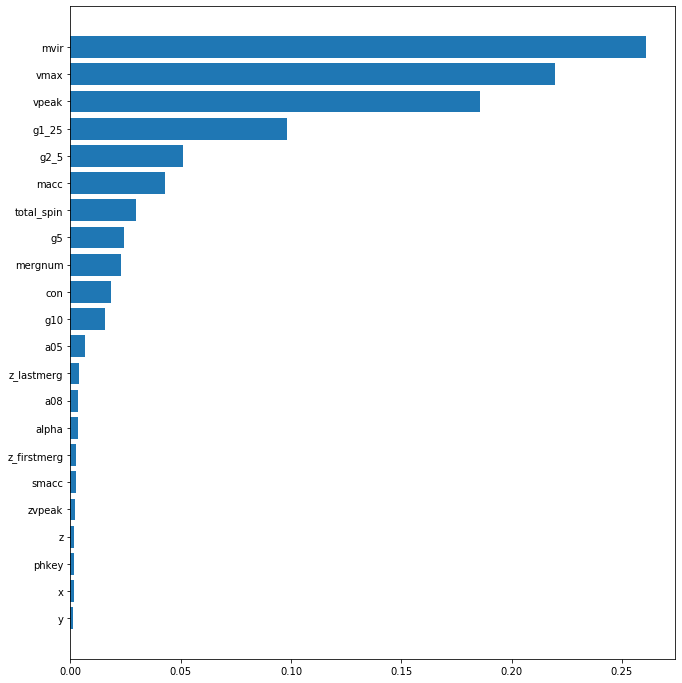

In [18]:
bar_plot(rfreg,X_train.columns,'feature_imp_full.pdf')

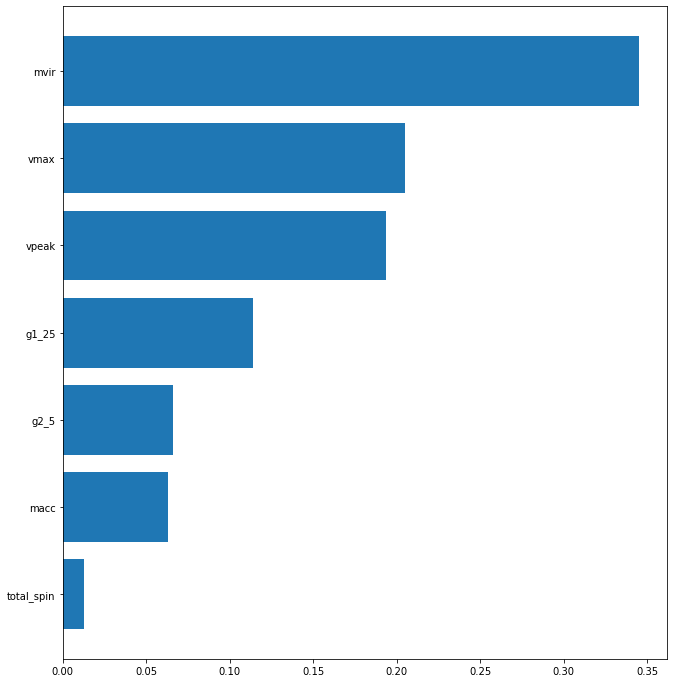

In [19]:
# Using top 7 features
feature_imp = rfreg.feature_importances_
features_arr = np.array(X_train.columns)

indices = np.argsort(feature_imp)

feature_pos = np.hstack((indices[-7:-1],indices[-1]))
halo_features_top = features_arr[feature_pos]

X = pd.get_dummies(halo_sample_shuffle[halo_features_top])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
rfreg_top = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfreg_top.fit(X_train, y_train);
pred_rfreg_top = rfreg_top.predict(X_val)

bar_plot(rfreg_top, X_train.columns, 'feature_imp_top.pdf')

In [20]:
def corr_mat(correlation,outfile):
    with PdfPages(outfile) as pdf:
        f, ax_hm = plt.subplots(figsize=(7, 7))
        ax_hm = sns.heatmap(correlation, 
        xticklabels=correlation.columns,
        yticklabels=correlation.columns, annot = True, square = True)
        ax_hm.set_ylim(len(correlation), -0.01)
        pdf.savefig()    

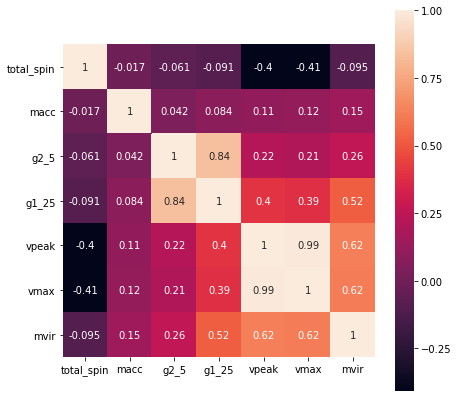

In [21]:
corr_mat(X.corr(),'heatmap_sat_top.pdf')

In [22]:
feature_uncorr_reg = ['mvir','vpeak','macc','g2_5','total_spin']

In [23]:
poly_features = PolynomialFeatures(degree=2, include_bias=True)
X_scale = X.copy()
X_scale[feature_uncorr_reg] = scaler.fit_transform(X_scale[feature_uncorr_reg])
X_poly = poly_features.fit_transform(X_scale)
X_train_poly, X_val_poly, y_train, y_val = train_test_split(X_poly, y, random_state = 0)

ridge_reg = Ridge(alpha=1E-3, solver="svd", random_state=0)
ridgereg_scores = cross_val_score(ridge_reg, X_poly, y,
                                scoring="r2", cv=5)
print(ridgereg_scores)
print(np.mean(ridgereg_scores),np.std(ridgereg_scores))

[0.93448279 0.94933325 0.88143464 0.93789057 0.89789483]
0.9202072155526407 0.025945997707461813


In [24]:
y = halo_sample_shuffle['Number of Sats'].to_numpy()
X = pd.get_dummies(halo_sample_shuffle[feature_uncorr_reg])
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

rfreg_uncorr = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfreg_uncorr.fit(X_train, y_train);

In [25]:
rfreg_uncorr_scores = cross_val_score(rfreg_uncorr, X, y, scoring="r2", cv=5)
print(rfreg_uncorr_scores)
print(np.mean(rfreg_uncorr_scores),np.std(rfreg_uncorr_scores))

[0.92860353 0.7932161  0.88249449 0.9301695  0.88473109]
0.8838429445168317 0.04973025594066147


## Predicting Central galaxy occupation: Classification

Central data has 8.76 million rows! We'll first go through the entire data set, classify halos with central galaxy mass < 1.42 as 0, and 1 otherwise. We'll then make a representative sample of the data set.

In [29]:
cent_data_cp = cent_data.copy()

cent_data_cp.loc[cent_data_cp['stellarMass'] < 1.42, 
                   'stellarMass'] = 0
cent_data_cp.loc[cent_data_cp['stellarMass'] > 1.42, 
                   'stellarMass'] = 1
cent_data_cp['stellarMass'] = cent_data_cp['stellarMass'].astype(int)

central_0 = cent_data_cp.loc[cent_data_cp['stellarMass'] == 0]
central_0 = index_reset_drop(central_0)

central_1 = cent_data_cp.loc[cent_data_cp['stellarMass'] == 1]
central_1 = index_reset_drop(central_1)


In [30]:
N = 100000
zero_num = central_0.shape[0]/cent_data_cp.shape[0]
zero_num *= N
zero_num = np.rint(zero_num)
zero_num = zero_num.astype(int)
more_num = N - zero_num

# Creating sample of 0-central halos
central_0_sample = central_0.sample(n=zero_num,random_state=0)
central_0_sample = index_reset_drop(central_0_sample)

# Creating sample of 1 central halos
central_1_sample = central_1.sample(n=more_num,random_state=0)
central_1_sample = index_reset_drop(central_1_sample)

central_both_sample = central_1_sample.append(central_0_sample, ignore_index = True)

array([[22579,   208],
       [  151,  2062]])

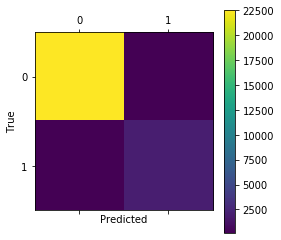

In [37]:
# Shuffling
central_both_shuffle = central_both_sample.sample(frac=1).reset_index(drop=True)

y = central_both_shuffle['stellarMass'].to_numpy()
X = pd.get_dummies(central_both_shuffle[halo_features_all])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

rfclass_full = RandomForestClassifier(n_estimators = 300, 
                max_depth = 20.0,min_samples_leaf = 10,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')

rfclass_full.fit(X_train, y_train);
pred_rfclass_cent = rfclass_full.predict(X_val)

In [125]:
def plot_conf_matrix(matrix,outfile):
    matrix_dnsty = np.zeros((2,2))
    matrix_dnsty[0,:] = matrix[0,:]/np.sum(matrix[0,:])
    matrix_dnsty[1,:] = matrix[1,:]/np.sum(matrix[1,:])
    plt.matshow(matrix_dnsty)
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    for i in range(2):
        for j in range(2):
            plt.text(i,j,str(np.around(matrix_dnsty[i,j],decimals=3)))
    with PdfPages(outfile) as pdf:
        pdf.savefig()

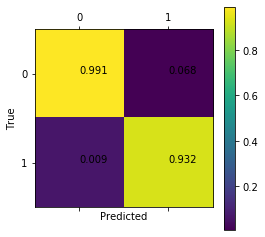

In [126]:
cm_cent = confusion_matrix(y_val, pred_rfclass_cent)
plot_conf_matrix(cm_cent,'confusion_matrix_full.pdf')

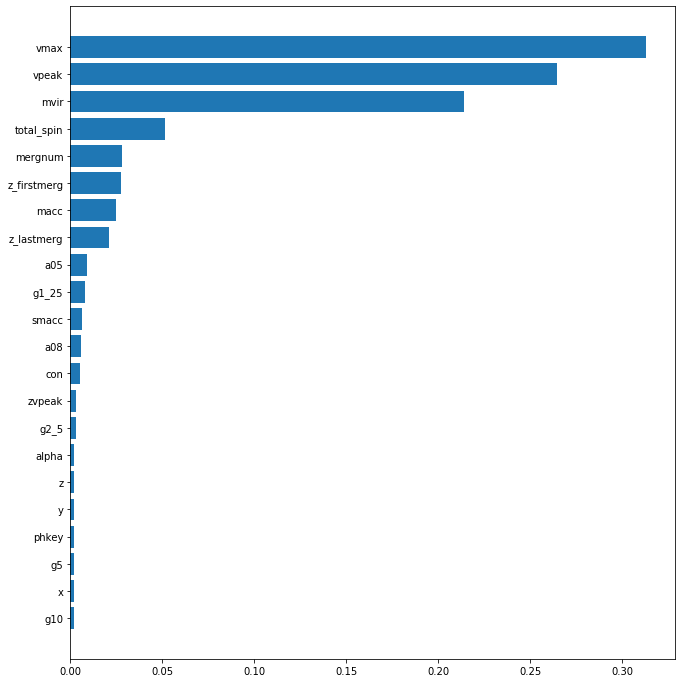

In [104]:
bar_plot(rfclass_full,X_train.columns,'feature_imp_full_cent.pdf')

In [39]:
tn, fp, fn, tp = confusion_matrix(y_val, pred_rfclass_cent).ravel()
recall = tp / (tp + fn)
prec = tp / (tp + fp)
accuracy = (tp + tn)/(tp + tn + fp + fn)
print(recall, prec, accuracy)
f1 = 2.0/((1.0/prec) + (1.0/recall))
print(f1)

0.9317668323542703 0.9083700440528635 0.98564
0.91991969663172


In [40]:
rfclass_full_scores = cross_val_score(rfclass_full, X, y, scoring="f1", cv=5)
print(rfclass_full_scores)
print(np.mean(rfclass_full_scores),np.std(rfclass_full_scores))

[0.91983852 0.91939618 0.91405576 0.91149425 0.91316849]
0.9155906421457489 0.003392041648111548


In [105]:
# Using top 7 features
feature_imp = rfclass_full.feature_importances_
features_arr = np.array(X_train.columns)

indices = np.argsort(feature_imp)

feature_pos = np.hstack((indices[-7:-1],indices[-1]))
central_features_top = features_arr[feature_pos]

X = pd.get_dummies(central_both_shuffle[central_features_top])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
rfclass_top = RandomForestClassifier(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')

rfclass_top.fit(X_train, y_train);
#pred_rfclass_top = rfclass_top.predict(X_val)

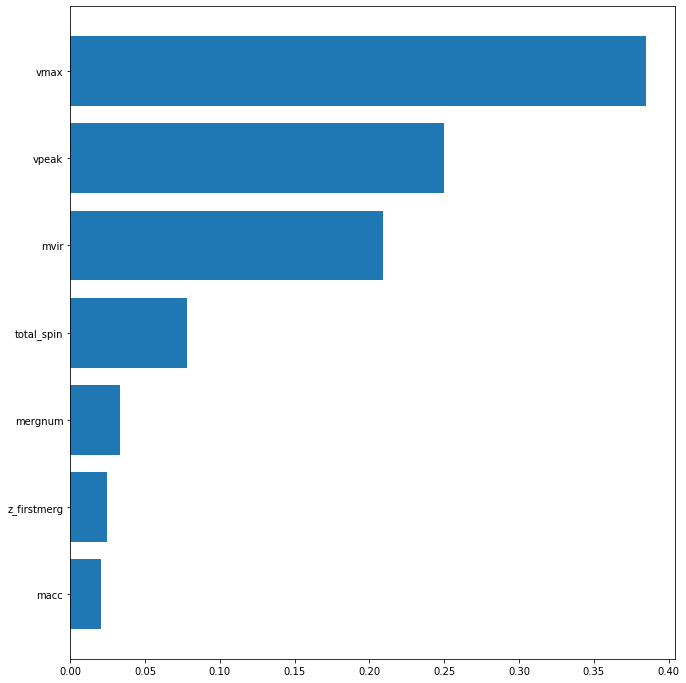

In [106]:
bar_plot(rfclass_top,X_train.columns,'feature_imp_top_cent.pdf')

In [107]:
rfclass_top_scores = cross_val_score(rfclass_top, X, y, scoring="f1", cv=5)
print(rfclass_top_scores)
print(np.mean(rfclass_top_scores),np.std(rfclass_top_scores))

[0.91217967 0.91580756 0.91370851 0.9027417  0.90694324]
0.9102761384726193 0.004772361502416144


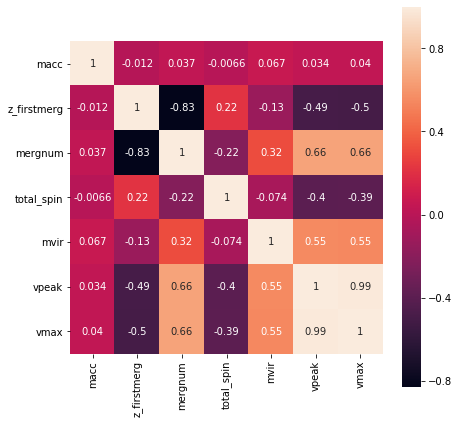

In [108]:
corr_mat(X.corr(),'heatmap_cent_top.pdf')

In [129]:
# Using only uncorrelated features
feature_uncorr_class = ['vmax','mvir','z_firstmerg','macc','total_spin']

X = pd.get_dummies(central_both_shuffle[feature_uncorr_class])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
rfclass_uncorr = RandomForestClassifier(n_estimators = 200, 
                max_depth = 20.0,min_samples_leaf = 6,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfclass_uncorr.fit(X_train, y_train);
#pred_rf_uncorr = rfclass_uncorr.predict(X_val)

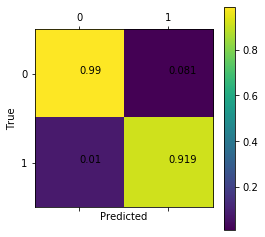

In [130]:
pred_rf_uncorr = rfclass_uncorr.predict(X_val)
cm_cent_uncorr = confusion_matrix(y_val, pred_rf_uncorr)
plot_conf_matrix(cm_cent_uncorr,'confusion_matrix_uncorr.pdf')

In [110]:
rfclass_uncorr_scores = cross_val_score(rfclass_uncorr, X, y, scoring="f1", cv=5)
print(rfclass_uncorr_scores)
print(np.mean(rfclass_uncorr_scores),np.std(rfclass_uncorr_scores))

[0.90700344 0.9089352  0.90825424 0.8974212  0.89597701]
0.9035182199627358 0.005620743476549644


## Strategy

Step 1: First _classify_ which halos will have no satellites with m > 1.42.
Define class 0 as those halos that have no satellites, and class 1 as those which have 1 or more satellites.

Step 2: Next, use a _regressor_ to predict the number of satellites halos of class 1 will have.

## Step 1 Training starts here

We'll proceed in 3 steps:

Step 1: Use all halo features to train a random forest classifier. Then plot feature importances to select the top most features.

Step 2: Run the RF classifier with the most important features.

Step 3: Plot a correlation matrix of the most important features, select the least correlated features, and then run the RF classifier.

__Step 1__

In [334]:
halo_features_all =  ['phkey','con','mvir','vmax','a05','a08','vpeak',
'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg',
'x','y','z','total_spin','g1_25','g2_5','g5','g10','alpha']

# Shuffling
halo_both_sample = halo_both_sample.sample(frac=1).reset_index(drop=True)

y = halo_both_sample['zero or one'].to_numpy()
X = pd.get_dummies(halo_both_sample[halo_features_all])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

rfclass_full = RandomForestClassifier(n_estimators = 300, 
                max_depth = 20.0,min_samples_leaf = 10,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')

array([[22809,   245],
       [  668,  1278]])

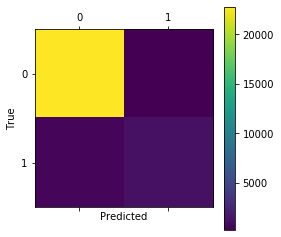

In [336]:
rfclass_full.fit(X_train, y_train);
pred_rfclass_full = rfclass_full.predict(X_val)
cm_full = confusion_matrix(y_val, pred_rfclass_full)
plt.matshow(cm_full)
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
cm_full

In [337]:
def bar_plot(rf, clmns, outfile):
    feature_imp = rf.feature_importances_
    features_arr = np.array(clmns)

    indices = np.argsort(feature_imp)

    with PdfPages(outfile) as pdf:
        fig = plt.figure(figsize=(12,12))
        ax = fig.add_subplot(111)
        plt.subplots_adjust(left = 0.2)
        ax.barh(range(len(indices)), feature_imp[indices])
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels([features_arr[i] for i in indices])
        pdf.savefig()

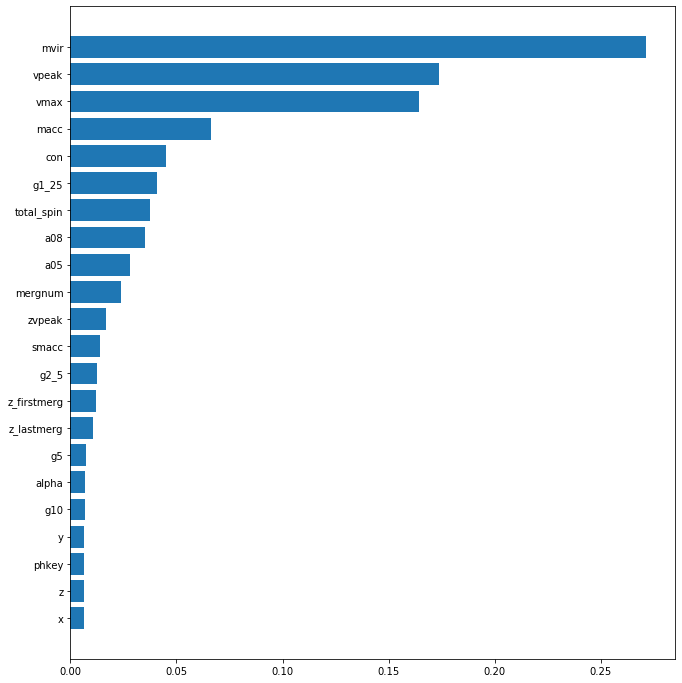

In [338]:
bar_plot(rfclass_full,X_train.columns,'feature_imp_full.pdf')

In [325]:
tn, fp, fn, tp = confusion_matrix(y_val, pred_rfclass_full).ravel()
recall = tp / (tp + fn)
prec = tp / (tp + fp)
accuracy = (tp + tn)/(tp + tn + fp + fn)
print(recall, prec, accuracy)
f1 = 2.0/((1.0/prec) + (1.0/recall))
print(f1)

0.6684607104413348 0.8263473053892215 0.96492
0.7390657542398096


In [326]:
rfclass_full_scores = cross_val_score(rfclass_full, X, y, scoring="f1", cv=5)
print(rfclass_full_scores)
print(np.mean(rfclass_full_scores),np.std(rfclass_full_scores))

[0.73942898 0.73798338 0.74018018 0.73282443 0.74047448]
0.7381782892819928 0.0028123342415645354


__Step 2__

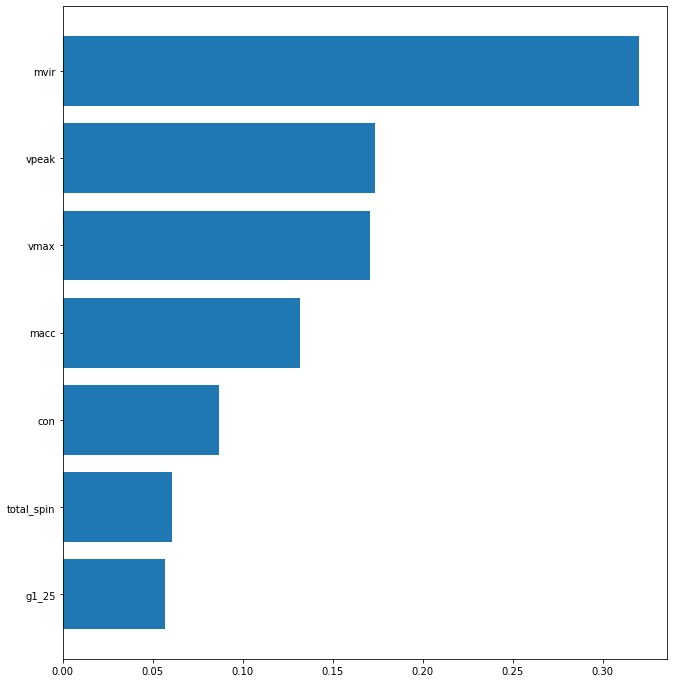

In [339]:
# Using top 7 features
feature_imp = rfclass_full.feature_importances_
features_arr = np.array(X_train.columns)

indices = np.argsort(feature_imp)

feature_pos = np.hstack((indices[-7:-1],indices[-1]))
halo_features_top = features_arr[feature_pos]

X = pd.get_dummies(halo_both_sample[halo_features_top])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
rfclass_top = RandomForestClassifier(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfclass_top.fit(X_train, y_train);
pred_rfclass_top = rfclass_top.predict(X_val)

bar_plot(rfclass_top, X_train.columns, 'feature_imp_top.pdf')

In [340]:
rfclass_top_scores = cross_val_score(rfclass_top, X, y, scoring="f1", cv=5)
print(rfclass_top_scores)
print(np.mean(rfclass_top_scores),np.std(rfclass_top_scores))

[0.73068592 0.72557471 0.7280364  0.72513369 0.72760116]
0.7274063761900645 0.0019854660652186733


In [329]:
def corr_mat(correlation,outfile):
    with PdfPages(outfile) as pdf:
        f, ax_hm = plt.subplots(figsize=(7, 7))
        ax_hm = sns.heatmap(correlation, 
        xticklabels=correlation.columns,
        yticklabels=correlation.columns, annot = True, square = True)
        ax_hm.set_ylim(len(correlation), -0.01)
        pdf.savefig()    

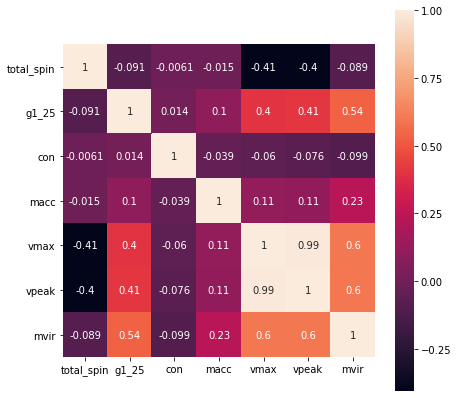

In [341]:
corr_mat(X.corr(),'heatmap_sat_class_red.pdf')

__Step 3__

In [344]:
# Using only uncorrelated features
feature_uncorr_class = ['mvir','vpeak','macc','con',
                        'a08','total_spin']

X = pd.get_dummies(halo_both_sample[feature_uncorr_class])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
rfclass_uncorr = RandomForestClassifier(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfclass_uncorr.fit(X_train, y_train);
pred_rf_uncorr = rfclass_uncorr.predict(X_val)

In [345]:
rfclass_uncorr_scores = cross_val_score(rfclass_uncorr, X, y, scoring="f1", cv=5)
print(rfclass_uncorr_scores)
print(np.mean(rfclass_uncorr_scores),np.std(rfclass_uncorr_scores))

[0.74050179 0.73837416 0.73680556 0.73236441 0.73706897]
0.737022975975153 0.002671309689009511


## Predictions for Step 1

Now making predictions on the entire halo data (~ 1.8 million)

In [346]:
X_full = pd.get_dummies(halo_full[feature_uncorr_class])
pred_full = rfclass_uncorr.predict(X_full)

In [347]:
y_full = halo_full['zero or one']
tn, fp, fn, tp = confusion_matrix(y_full, pred_full).ravel()
recall = tp / (tp + fn)
prec = tp / (tp + fp)
accuracy = (tp + tn)/(tp + tn + fp + fn)
print(recall, prec, accuracy)
f1 = 2.0/((1.0/prec) + (1.0/recall))
print(f1)

0.669763835037011 0.8281555090655509 0.9636365225724218
0.7405854152862766


## Step 2

Now run a regressor to predict number of satellites a halo of class 1 from above will have

In [348]:
# sat_num.to_numpy() gives the values of the 2nd column (# of sats)
# in sat_num

sat_num = sat_data_above['fofID'].value_counts()
sat_num_np = sat_num.to_numpy()

# ground_truth_above contains 2 columns: haloIDs and # of sats

ground_truth_above = pd.DataFrame({'fofID': haloID_above, 
                    'Number of Sats': sat_num_np})

We now have a pd df, _ground_truth_above_, which contains haloIDs and # of sats, arranged in descending order of # of sats. We then need to first pick _haloID_above_ from the central data, and then assign _sat_num_np_ to the halos selected. This is done in two steps:

1) We sort _ground_truth_above_ by fofID.

2) We sort _halo_above_ by fofID. 

In [349]:
ground_truth_above_sort = ground_truth_above.sort_values(by = ['fofID'])
ground_truth_above_sort = index_reset_drop(ground_truth_above_sort)

halo_above_sort = halo_above.sort_values(by = ['fofID'])
halo_above_sort = index_reset_drop(halo_above_sort)

halo_above_sort['Number of Sats'] = ground_truth_above_sort['Number of Sats']

# Shuffle
halo_above_sort = halo_above_sort.sample(frac=1,random_state=0).reset_index(drop=True)

## Step 2 training starts here

In [350]:
y = halo_above_sort['Number of Sats'].to_numpy()
X = pd.get_dummies(halo_above_sort[halo_features_all])
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

In [351]:
rfreg_all = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfreg_all.fit(X_train, y_train);
pred_rfreg_all = rfreg_all.predict(X_val)

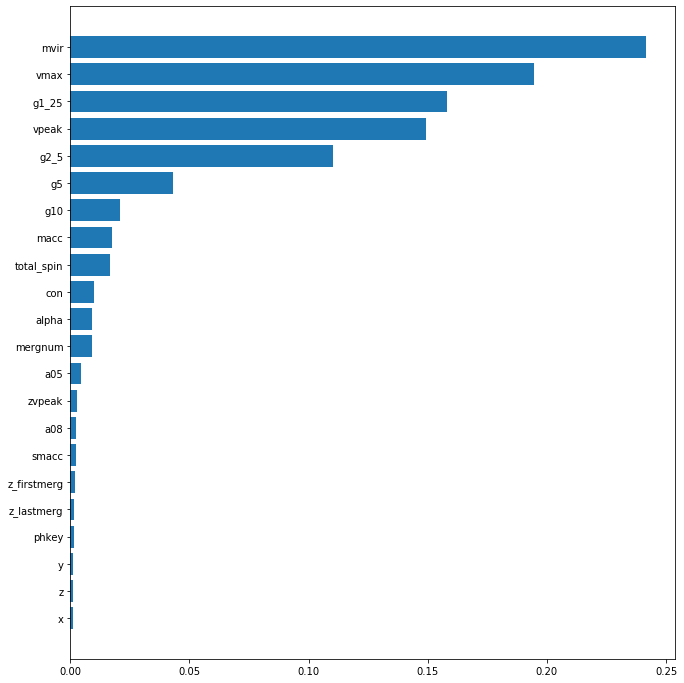

In [352]:
bar_plot(rfreg_all,X_train.columns,'feature_imp_sat_reg_full.pdf')

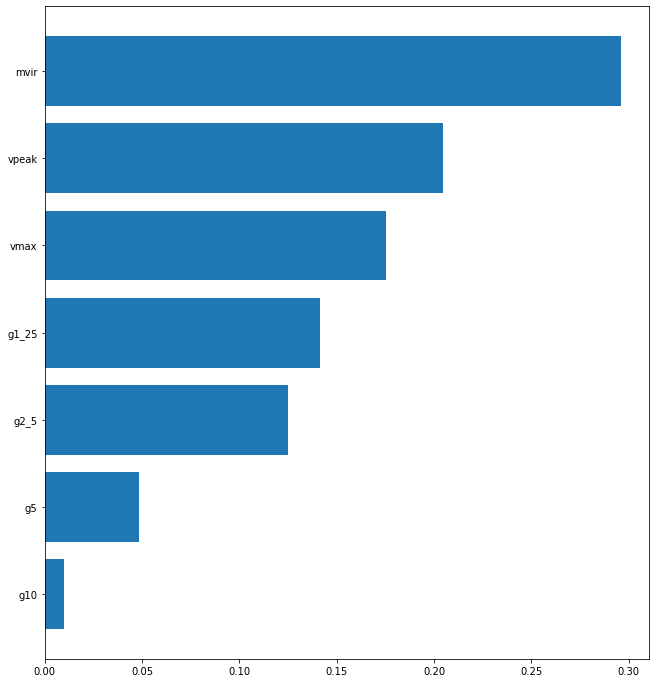

In [353]:
feature_imp = rfreg_all.feature_importances_
features_arr = np.array(X_train.columns)
indices = np.argsort(feature_imp)

feature_pos = np.hstack((indices[-7:-1],indices[-1]))
halo_features_top = features_arr[feature_pos]

X = pd.get_dummies(halo_above_sort[halo_features_top])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
rfreg_top = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfreg_top.fit(X_train, y_train);
pred_rfreg_top = rfreg_top.predict(X_val)

bar_plot(rfreg_top,X_train.columns,'feature_imp_sat_reg_top.pdf')

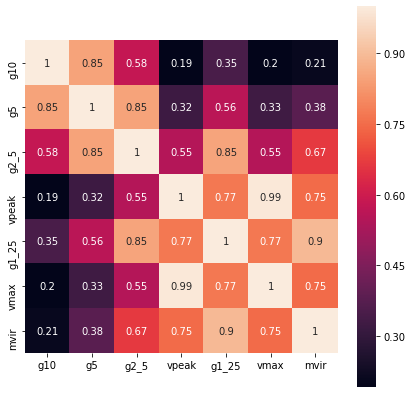

In [354]:
corr_mat(X.corr(),'heatmap_sat_reg_red.pdf')

In [355]:
feature_uncorr_reg = ['mvir','vpeak','g2_5','g5','g10']

X = pd.get_dummies(halo_above_sort[feature_uncorr_reg])

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)
rfreg_uncorr = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfreg_uncorr.fit(X_train, y_train);
pred_rf_uncorr = rfreg_uncorr.predict(X_val)

In [356]:
rfreg_uncorr_scores = cross_val_score(rfreg_uncorr, X, y, scoring="r2", cv=5)
print(rfreg_uncorr_scores)
print(np.mean(rfreg_uncorr_scores),np.std(rfreg_uncorr_scores))

[0.93452103 0.93173127 0.93375153 0.89924122 0.91663508]
0.9231760261160918 0.013633793118745262


In [357]:
poly_features = PolynomialFeatures(degree=2, include_bias=True)
X_scale = X.copy()
X_scale[feature_uncorr_reg] = scaler.fit_transform(X_scale[feature_uncorr_reg])
X_poly = poly_features.fit_transform(X_scale)
X_train_poly, X_val_poly, y_train, y_val = train_test_split(X_poly, y, random_state = 0)

ridge_reg = Ridge(alpha=0.01, solver="svd", random_state=0)
ridgereg_scores = cross_val_score(ridge_reg, X_poly, y,
                                scoring="r2", cv=5)
print(ridgereg_scores)
print(np.mean(ridgereg_scores),np.std(ridgereg_scores))

[0.92900913 0.92525613 0.92946349 0.94138205 0.93848777]
0.9327197138460159 0.006138126546016571


In [358]:
print(np.mean(rfreg_uncorr_scores),np.std(rfreg_uncorr_scores))

0.9231760261160918 0.013633793118745262


## Predictions for Step 2

In [359]:
ridge_reg.fit(X_train_poly,y_train)
pred_ridge_reg = ridge_reg.predict(X_poly)
r2_score(pred_ridge_reg,y)

0.9320460487268594

## Setting up predictions for a new data set 

This data set only contains halo properties for which we must predict number of halos   

In [360]:
X_full_cp = cent_data.copy()
X_full = pd.get_dummies(cent_data[feature_uncorr_class])
pred_full = rfclass_uncorr.predict(X_full)
    
X_full_cp['Predicted number of satellites'] = pred_full
X_more = X_full_cp.loc[X_full_cp['Predicted number of satellites'] == 1]
X_none = X_full_cp.loc[X_full_cp['Predicted number of satellites'] == 0]

In [361]:
X_more_reg = pd.get_dummies(X_more[feature_uncorr_reg])
pred_rf_full = rfreg_uncorr.predict(X_more_reg)

In [362]:
X_more_cp = X_more.copy()
X_more_cp['Predicted number of satellites'] = pred_rf_full
X_more = X_more_cp.copy()

X_none_cp = X_none.copy()
X_none_cp['Predicted number of satellites'] = 0
X_none = X_none_cp.copy()

In [363]:
X_full_new = X_none.append(X_more)

In [364]:
X_full_sort = X_full_new.sort_values(by = 'fofID')
X_full_sort = index_reset_drop(X_full_sort)

## Testing regression model on entire satellite data

In [380]:
halo_above_sample2 = halo_above_sort.sample(n=more_num,random_state=0).reset_index(drop=True)
halo_above_sample2 = index_reset_drop(halo_above_sample2)
halo_below_sample2 = halo_below.sample(n=zero_num,random_state=0)
halo_below_sample2 = index_reset_drop(halo_below_sample2)
halo_below_sample2['Number of Sats'] = 0
halo_sample2 = halo_above_sample2.append(halo_below_sample2, ignore_index = True)

halo_sample2 = halo_sample2.sample(frac=1).reset_index(drop=True)
halo_sample2 = index_reset_drop(halo_sample2)

In [383]:
y = halo_sample2['Number of Sats'].to_numpy()
X = pd.get_dummies(halo_sample2[halo_features_all])
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 0)

rfreg_2 = RandomForestRegressor(n_estimators = 100, 
                max_depth = 20.0,min_samples_leaf = 5,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')
rfreg_2.fit(X_train, y_train);
pred_rfreg_all = rfreg_2.predict(X_val)

In [387]:
rfreg_uncorr_scores_2 = cross_val_score(rfreg_2, X, y, scoring="r2", cv=5)
print(rfreg_uncorr_scores_2)
print(np.mean(rfreg_uncorr_scores_2),np.std(rfreg_uncorr_scores_2))

[0.89881273 0.90141296 0.88945142 0.91353624 0.87460223]
0.8955631129385745 0.012996348539601858


In [388]:
X_above = pd.get_dummies(halo_above_sample2[halo_features_all])
pred_rfreg2_above = rfreg_2.predict(X_above)

In [418]:
haloID_sample2 = halo_sample2['fofID'].unique()
sample2_sort = X_full_sort[X_full_sort['fofID'].isin(haloID_sample2)]
sample2_sort = index_reset_drop(sample2_sort)

In [412]:
halo_sample2_sort = halo_sample2.sort_values(by = 'fofID')
halo_sample2_sort = index_reset_drop(halo_sample2_sort)
X_sample2_sort = pd.get_dummies(halo_sample2_sort[halo_features_all])
pred_rfreg2 = rfreg_2.predict(X_sample2_sort)
pred_rfreg2 = np.rint(pred_rfreg2)

In [428]:
r2_score(pred_rfreg2,halo_sample2_sort['Number of Sats'])

0.9041455162085756

In [436]:
r2_score(sample2_sort['Predicted number of satellites'],
         halo_sample2_sort['Number of Sats'])

0.9085206712998282

## Testing the original Central data set

In [386]:
X_full_sort_above = X_full_sort[X_full_sort['fofID'].isin(haloID_above)]
y_above_true = ground_truth_above_sort['Number of Sats']
y_above_pred = X_full_sort_above['Predicted number of satellites']

r2_score(y_above_pred,y_above_true)

0.9387642587611655

In [271]:
X_full_sort_below = X_full_sort[X_full_sort['fofID'].isin(haloID_below)]
y_below_true = halo_below['zero or one']
y_below_pred = X_full_sort_below['Predicted number of satellites']
y_below_pred = index_reset_drop(y_below_pred)
zero_pred = y_below_pred[y_below_pred['Predicted number of satellites'] == 0.]

#print(zero_pred.shape[0]/y_below_true.shape[0])

0.9881765090141977


array([[22666,   207],
       [  152,  1975]])

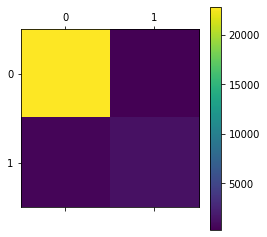

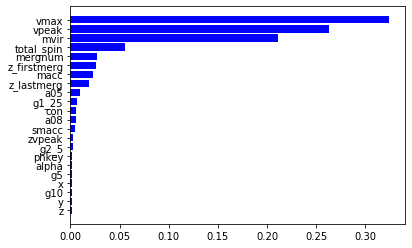

In [47]:
with PdfPages('feature_imp_full.pdf') as export_pdf:
    feature_imp = rfclass_full.feature_importances_
    features_arr = np.array(X_train.columns)

    indices = np.argsort(feature_imp)
    plt.barh(range(len(indices)), feature_imp[indices], color='b', align='center');
    plt.yticks(range(len(indices)), [features_arr[i] for i in indices]);
    export_pdf.savefig()

0.9285378467324871 0.9051329055912007 0.98564
0.9166860060338826


[0.919233   0.91980454 0.92094634 0.91973341 0.91935484]
0.9198144261502879 0.0006061605414067378


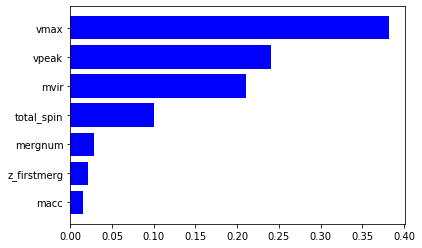

[0.9170076  0.91467969 0.9136939  0.91736735 0.91810842]
0.9161713922740781 0.0016878848665957018


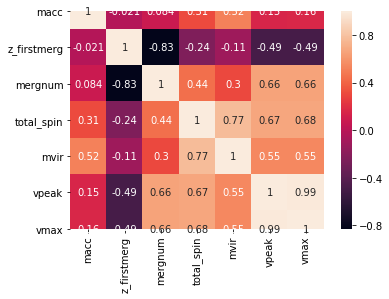

[0.90988626 0.91123919 0.90903857 0.91451753 0.90993072]
0.910922455327456 0.001930344397451475


## Predictions for Central occupancy

In [55]:
X_full = pd.get_dummies(cent_data[feature_uncorr_class])
pred_full = rfclass_uncorr.predict(X_full)

In [56]:
y_full = cent_data_cp['stellarMass']
tn, fp, fn, tp = confusion_matrix(y_full, pred_full).ravel()
recall = tp / (tp + fn)
prec = tp / (tp + fp)
accuracy = (tp + tn)/(tp + tn + fp + fn)
print(recall, prec, accuracy)
f1 = 2.0/((1.0/prec) + (1.0/recall))
print(f1)

0.9229846339663155 0.8921708268148598 0.9839730121730831
0.9073161851037839


In [57]:
cent_data_cp['Predicted Central Occupancy'] = pred_full
cent_data_cp_sort = cent_data_cp.sort_values(by = 'fofID')
cent_data_cp_sort = cent_data_cp_sort.reset_index()
cent_data_cp_sort = cent_data_cp_sort.drop(columns = ['index'])

cent_data_cp_sort['Predicted number of satellites'] = X_full_sort['Predicted number of satellites']


In [58]:
cent_data_sort = cent_data.sort_values(by = 'fofID')
cent_data_sort = cent_data_sort.reset_index()
cent_data_sort = cent_data_sort.drop(columns = ['index'])

cent_data_sort['Predicted number of satellites'] = cent_data_cp_sort['Predicted number of satellites']
cent_data_sort['Predicted Central Occupancy'] = cent_data_cp_sort['Predicted Central Occupancy'] 

## Binning

0.06887649282632247
[[2854    0    0    0]
 [ 102    0    0    0]
 [  11    0    0    0]
 [   1    0    0    0]]


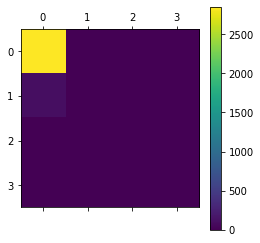

In [295]:
halo_bin_features =  ['phkey','con','mvir','vmax','a05','a08','vpeak',
'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg',
'x','y','z','type','total_spin','g1_25','g2_5','g5','g10','alpha']
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

#halo_bin_features = ['mvir','vpeak','g2_5','g5']

N = 6
features_arr = np.array(halo_bin_features)
feature_imp = np.zeros((N,features_arr.shape[0]))
indices = np.zeros((N,features_arr.shape[0]))

for j in range(1,2):
    halo_data_bin = halo_cen_unq_sort[(halo_cen_unq_sort['centralMvir'] < 10.**(j+1)) &
                (halo_cen_unq_sort['centralMvir'] > 10.**(j))]
    halo_data_bin = halo_data_bin.reset_index()
    halo_data_bin = halo_data_bin.drop(columns = ['index'])
    halo_ID_bin = halo_data_bin['fofID']

    ground_truth_bin = ground_truth_sort[ground_truth_sort['fofID'].isin(halo_ID_bin)]
    ground_truth_bin = ground_truth_bin.reset_index()
    ground_truth_bin = ground_truth_bin.drop(columns = ['index']) 
                                       
    y_bin = ground_truth_bin['Number of Sats'].to_numpy()
    X_bin = pd.get_dummies(halo_data_bin[halo_bin_features])
                                       
    X_bin_train, X_bin_val, y_bin_train, y_bin_val = train_test_split(X_bin, y_bin, random_state = 0)
#    y_bin_val_arr = np.zeros((N,y_bin_train.shape[0])) 
#    pred_rf_arr = np.zeros_like(y_bin_val)
#    X_bin_val_arr = np.zeros_like(y_bin_val)
#    y_bin_val_arr[j,:] = y_bin_val
#    pred_rf_arr[j,:] = pred_rf
#    X_bin_val_arr[j,:] = X_bin_val
    rfreg_bin = RandomForestRegressor(n_estimators = 100, 
                max_depth = 5.0,min_samples_leaf = 3,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')

    rfclass_bin = RandomForestClassifier(n_estimators = 100, 
                max_depth = 5.0,min_samples_leaf = 3,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')

    rfreg_bin.fit(X_bin_train, y_bin_train);
    pred_rf = rfreg_bin.predict(X_bin_val)
    print(r2_score(y_bin_val,pred_rf))

    rfclass_bin.fit(X_bin_train, y_bin_train);
    pred_rf = rfclass_bin.predict(X_bin_val)
    cm = confusion_matrix(y_bin_val, pred_rf)
    plt.matshow(cm)
    plt.colorbar()

    print(cm)    
    feature_imp[j,:] = rfreg_bin.feature_importances_

    indices[j,:] = np.argsort(feature_imp[j,:])                     


In [258]:
import collections, numpy

print(collections.Counter(pred_rf), 
      collections.Counter(y_bin_val))

Counter({1: 2968}) Counter({1: 2854, 2: 102, 3: 11, 4: 1})


In [326]:
X_bin_cp = X_bin.copy()
X_bin_cp['num_sat'] = y_bin
X_bin_cp.tail()

,phkey,con,mvir,vmax,a05,a08,vpeak,zvpeak,macc,smacc,...,y,z,type,total_spin,g1_25,g2_5,g5,g10,alpha,num_sat
11865,16762807,0.949853,97.684540,153.26578,0.643761,0.876447,195.39769,0.089288,-261.507308,-2.677059,...,16.663414,472.22916,0,3.392575,8.227546,3.350343,1.166894,0.908859,0.650985,1
11866,16758939,1.116512,49.487762,143.61821,0.463865,0.491220,153.46486,0.623590,-36.412346,-0.735785,...,42.278080,473.09120,0,1.970662,3.749091,3.793927,2.711788,1.705927,0.275349,1
11867,16771808,1.157878,77.459110,172.92862,0.331289,0.764481,203.03825,0.019933,-26.481538,-0.341878,...,25.969719,448.89710,0,3.263480,5.900879,4.619894,2.528303,1.177535,0.384606,1
11868,16752035,1.187418,77.975494,177.73372,0.415625,0.719962,178.04948,0.019933,-46.343308,-0.594332,...,57.536346,441.98224,0,4.586824,2.201721,1.470524,1.160839,1.031394,0.825774,1
11869,16754841,1.031447,55.082030,137.49818,0.519315,0.790902,148.65695,0.242469,-16.551154,-0.300482,...,40.149050,462.37775,0,2.181708,2.124331,2.115950,2.133400,1.283053,0.416986,1


In [327]:
outlier = X_bin_cp.loc[X_bin_cp['num_sat'] != 1]
outlier = outlier.reset_index()
outlier = outlier.drop(columns = ['index'])
outlier['con_new'] = outlier.con

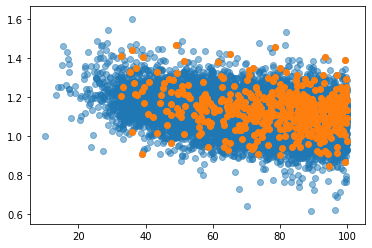

In [328]:
plt.scatter(X_bin.mvir,X_bin.con,alpha=0.5)
plt.scatter(outlier.mvir,outlier.con_new)

In [321]:
X_bin_cp.loc[X_bin_cp['num_sat'] != 1, 'con']= 1.1*(X_bin_cp.con)



In [305]:
X_bin_cp

,phkey,con,mvir,vmax,a05,a08,vpeak,zvpeak,macc,smacc,...,y,z,type,total_spin,g1_25,g2_5,g5,g10,alpha,num_sat
0,5767,1.112402,96.823880,178.96555,0.431211,0.569789,192.94147,1.077875,-92.686154,-0.957265,...,21.525980,37.102856,0,1.291159,4.077098,2.535460,1.190493,0.951082,0.803949,1
1,24109,1.078663,70.832050,156.36598,0.378137,0.778536,167.37381,1.630271,76.135000,1.074867,...,57.445385,40.581707,0,1.796679,14.375061,3.298037,1.633542,1.346350,0.580303,1
2,14246,1.176147,73.844345,172.88109,0.379887,0.562842,181.43068,0.687109,62.894038,0.851711,...,9.290336,24.249660,0,1.948388,2.042845,1.168416,0.927144,0.989585,0.887937,1
3,7080,1.164101,92.262400,184.29446,0.379969,0.649457,208.81897,1.385718,-19.861154,-0.215268,...,22.811821,60.532032,0,0.362541,4.362735,4.172705,1.897275,1.046074,0.320896,1
4,3266,1.263387,80.815670,191.37340,0.406701,0.452867,219.74792,1.173417,62.894231,0.778243,...,22.676504,18.497011,0,0.240367,6.916746,4.510846,2.999653,1.838928,0.301295,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11865,16762807,0.949853,97.684540,153.26578,0.643761,0.876447,195.39769,0.089288,-261.507308,-2.677059,...,16.663414,472.229160,0,3.392575,8.227546,3.350343,1.166894,0.908859,0.650985,1
11866,16758939,1.116512,49.487762,143.61821,0.463865,0.491220,153.46486,0.623590,-36.412346,-0.735785,...,42.278080,473.091200,0,1.970662,3.749091,3.793927,2.711788,1.705927,0.275349,1
11867,16771808,1.157878,77.459110,172.92862,0.331289,0.764481,203.03825,0.019933,-26.481538,-0.341878,...,25.969719,448.897100,0,3.263480,5.900879,4.619894,2.528303,1.177535,0.384606,1
11868,16752035,1.187418,77.975494,177.73372,0.415625,0.719962,178.04948,0.019933,-46.343308,-0.594332,...,57.536346,441.982240,0,4.586824,2.201721,1.470524,1.160839,1.031394,0.825774,1


0.20288540173745706
[[2854    0    0    0]
 [ 102    0    0    0]
 [  11    0    0    0]
 [   1    0    0    0]]


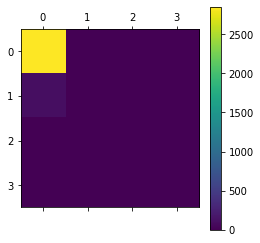

In [322]:
halo_bin_features =  ['phkey','con','mvir','vmax','a05','a08','vpeak',
'zvpeak','macc','smacc','mergnum','z_firstmerg','z_lastmerg',
'x','y','z','type','total_spin','g1_25','g2_5','g5','g10','alpha']

#halo_bin_features = ['mvir','vpeak','g2_5','g5']

N = 6
features_arr = np.array(halo_bin_features)
feature_imp = np.zeros((N,features_arr.shape[0]))
indices = np.zeros((N,features_arr.shape[0]))

for j in range(1,2):                                       
    X_bin_cp1 = pd.get_dummies(X_bin_cp[halo_bin_features])
    X_bin_train, X_bin_val, y_bin_train, y_bin_val = train_test_split(X_bin_cp1, y_bin, random_state = 0)
    rfreg_bin = RandomForestRegressor(n_estimators = 100, 
                max_depth = 5.0,min_samples_leaf = 3,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')

    rfclass_bin = RandomForestClassifier(n_estimators = 100, 
                max_depth = 5.0,min_samples_leaf = 3,
                n_jobs = -1,oob_score = True,random_state = 0,
                max_features='log2')

    rfreg_bin.fit(X_bin_train, y_bin_train);
    pred_rf = rfreg_bin.predict(X_bin_val)
    print(r2_score(y_bin_val,pred_rf))

    rfclass_bin.fit(X_bin_train, y_bin_train);
    pred_rf = rfclass_bin.predict(X_bin_val)
    cm = confusion_matrix(y_bin_val, pred_rf)
    plt.matshow(cm)
    plt.colorbar()

    print(cm)    

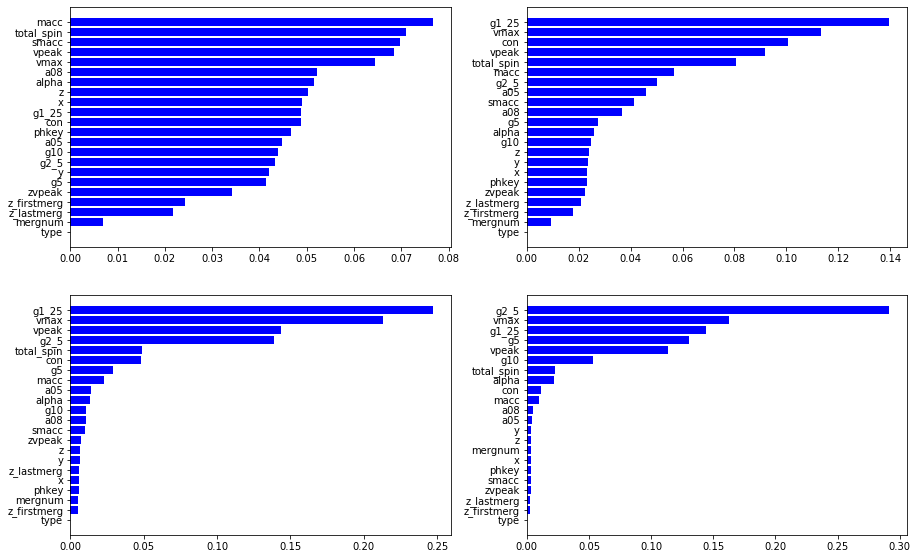